- Effectuer deux requêtes différentes en mode batch avec état (dont une sans fenêtre)


# Init OpenSkyNetwork into Kafka

In [3]:
import requests
from kafka import KafkaProducer
import json

def send_openskynetwork_to_kafka(topic, url, fields={}):

    # Kafka configuration
    kafka_config = {
        'bootstrap_servers': 'kafka1:9092',  # Update with your Kafka broker
    }

    # Initialize Kafka Producer
    producer = KafkaProducer(
        bootstrap_servers=kafka_config['bootstrap_servers'],
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

    # Fetch data from OpenSkyNetwork
    
    response = requests.get(url)

    if response.status_code == 200:
        datas = response.json()
        for data in datas:
            # Send data to Kafka
            producer.send(topic, value=data)

            # Ensure all messages are sent
            producer.flush()
        print(f"Sent {len(datas)} records.")
    else:
        print(f"Failed to fetch data: {response.status_code}")

# Init beginning

In [ ]:
from datetime import datetime, timedelta
# "icao24": "3c660d",
# "firstSeen": 1517223009,
# "estDepartureAirport": null,
# "lastSeen": 1517227287,
# "estArrivalAirport": "EDDF",
# "callsign": "DLH811  ",
# "estDepartureAirportHorizDistance": null,
# "estDepartureAirportVertDistance": null,
# "estArrivalAirportHorizDistance": 1498,
# "estArrivalAirportVertDistance": 103,
# "departureAirportCandidatesCount": 0,
# "arrivalAirportCandidatesCount": 2


# api doc https://openskynetwork.github.io/opensky-api/rest.html
api_url = "https://opensky-network.org/api/flights/arrival?airport={}&begin={}&end={}"

# Airport code
airports = ["EDDF", "EDDM", "EDDB", "LOWS", "LFPG", "EHAM", "LEMD", "LIRF", "LEBL"]

# durée de récupération (minutes)
step = 60*24*7

# 7 derniers jours
end = datetime.now()
begin = end - timedelta(minutes=step)



# Appel OpenSkyNetwork

In [18]:
for airport in airports:
    print(api_url.format(airport, int(begin.timestamp()), int(end.timestamp())))
    send_openskynetwork_to_kafka("arrivals", api_url.format(airport, int(begin.timestamp()), int(end.timestamp())))

https://opensky-network.org/api/flights/arrival?airport=EDDF&begin=1739123649&end=1739728449
Failed to fetch data: 429
https://opensky-network.org/api/flights/arrival?airport=EDDM&begin=1739123649&end=1739728449
Failed to fetch data: 429
https://opensky-network.org/api/flights/arrival?airport=EDDB&begin=1739123649&end=1739728449
Failed to fetch data: 429
https://opensky-network.org/api/flights/arrival?airport=LOWS&begin=1739123649&end=1739728449
Failed to fetch data: 429
https://opensky-network.org/api/flights/arrival?airport=LFPG&begin=1739123649&end=1739728449
Failed to fetch data: 429
https://opensky-network.org/api/flights/arrival?airport=EHAM&begin=1739123649&end=1739728449
Failed to fetch data: 429
https://opensky-network.org/api/flights/arrival?airport=LEMD&begin=1739123649&end=1739728449
Failed to fetch data: 429
https://opensky-network.org/api/flights/arrival?airport=LIRF&begin=1739123649&end=1739728449
Failed to fetch data: 429
https://opensky-network.org/api/flights/arrival?

# Init Spark

In [7]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext, SparkConf

conf = SparkConf() \
    .setAppName('SparkApp') \
    .setMaster('spark://spark:7077') \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .set("spark.sql.shuffle.partitions", "10")
 

sc = SparkContext.getOrCreate(conf=conf)

# Créer un SQLContext pour les opérations SQL
sql_context = SQLContext(sc)


:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-656ad5a0-6424-41f9-9e21-7d3c8cee810c;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.3 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.3 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, FloatType
from pyspark.sql.functions import col, desc, sum, mean, min, max, lit, coalesce, bucket, from_json, col, window, avg


# Kafka configuration
kafka_broker = "kafka1:9092"
kafka_topic = "arrivals"

# "icao24": "3c660d",
# "firstSeen": 1517223009,
# "estDepartureAirport": null,
# "lastSeen": 1517227287,
# "estArrivalAirport": "EDDF",
# "callsign": "DLH811  ",
# "estDepartureAirportHorizDistance": null,
# "estDepartureAirportVertDistance": null,
# "estArrivalAirportHorizDistance": 1498,
# "estArrivalAirportVertDistance": 103,
# "departureAirportCandidatesCount": 0,
# "arrivalAirportCandidatesCount": 2

# Define schema for the Kafka message
schema = StructType([
    StructField("lastSeen", IntegerType(), True),
    StructField("estArrivalAirport", StringType(), True)
])

# Read raw data from Kafka
raw_stream = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", kafka_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Parse Kafka messages
parsed_stream = raw_stream.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema).alias("data")) \
    .select(
        col("data.lastSeen").cast(TimestampType()).alias("ArrivalTime"),
        col("data.estArrivalAirport").alias("Airport")
    )



# Compute number of arrivals over a 5-minute window
rolling_numbers = parsed_stream \
    .groupBy(window(col("ArrivalTime"), "60 minutes")) \
    .count() \
    .select(
        col("window.start").alias("window_start"),
        col("window.end").alias("window_end"),
        col("count").alias("num_arrivals")
    ).orderBy("window_start")
rolling_numbers

DataFrame[window_start: timestamp, window_end: timestamp, num_arrivals: bigint]

25/02/16 17:59:59 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


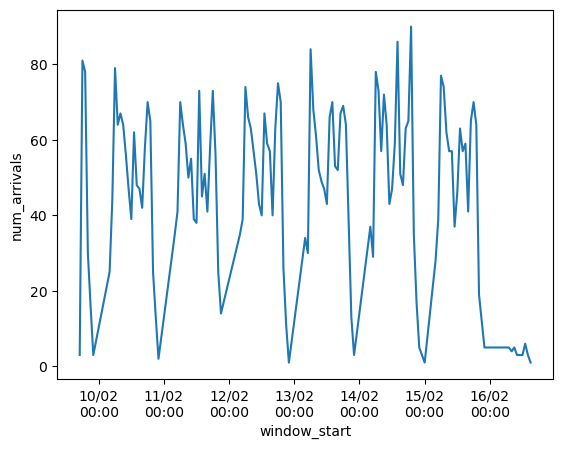

In [9]:

# Collect the result as a Pandas DataFrame
pandas_df = rolling_numbers.toPandas()
pandas_df

import seaborn as sns
import matplotlib.dates as md

g = sns.lineplot(data=pandas_df, x="window_start", y="num_arrivals")
g.xaxis.set_major_formatter(md.DateFormatter('%d/%m\n%H:%M'))


Nous observons un pattern réccurent sur l'atterrissage des avions par jour.

# mode batch sans fenêtre

In [16]:
# "icao24": "3c660d",
# "firstSeen": 1517223009,
# "estDepartureAirport": null,
# "lastSeen": 1517227287,
# "estArrivalAirport": "EDDF",
# "callsign": "DLH811  ",
# "estDepartureAirportHorizDistance": null,
# "estDepartureAirportVertDistance": null,
# "estArrivalAirportHorizDistance": 1498,
# "estArrivalAirportVertDistance": 103,
# "departureAirportCandidatesCount": 0,
# "arrivalAirportCandidatesCount": 2

# Define schema for the Kafka message
schema = StructType([
    StructField("icao24", StringType(), True),
    StructField("firstSeen", IntegerType(), True),
    StructField("estDepartureAirport", StringType(), True),
    StructField("lastSeen", IntegerType(), True),
    StructField("estArrivalAirport", StringType(), True),
    StructField("callsign", StringType(), True),
    StructField("estDepartureAirportHorizDistance", IntegerType(), True),
    StructField("estDepartureAirportVertDistance", IntegerType(), True),
    StructField("estArrivalAirportHorizDistance", IntegerType(), True),
    StructField("estArrivalAirportVertDistance", IntegerType(), True),
    StructField("departureAirportCandidatesCount", IntegerType(), True),
    StructField("arrivalAirportCandidatesCount", IntegerType(), True)
])


# Charger les données depuis Kafka 
df = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", kafka_topic) \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load()

# Convertir la valeur en String et parser le JSON
flight_data = df \
    .selectExpr("CAST(value AS STRING)") \
    .select(from_json(col("value"), schema) \
    .alias("data")) \
    .select("data.*")

# creer un DF pour le nombre de vols entre chaque paire origine-destination
flight_counts = flight_data \
    .groupBy("estDepartureAirport", "estArrivalAirport") \
    .count() \
    .withColumnRenamed("count", "flight_count")

# Créer un DataFrame pour les arêtes (vols)
nbVols = flight_counts.select(
    col("estDepartureAirport").alias("src"),
    col("estArrivalAirport").alias("dst"),
    col("flight_count")
)
# on se limite au 15 aéroports les plus fréquentés
top_n = 15

# Identifier les aéroports les plus fréquentés (combinaison de départs et arrivées)
top_airports = (
    flight_counts.select("estDepartureAirport").union(flight_counts.select("estArrivalAirport"))
    .groupBy("estDepartureAirport").count()
    .orderBy(desc("count"))
    .limit(top_n)
    .select("estDepartureAirport").collect()
)
top_airport_codes = [row['estDepartureAirport'] for row in top_airports]

# Filtrer le dataframe pour n'inclure que les vols entre ces aéroports principaux
filtered_counts = flight_counts.filter(
    (col("estDepartureAirport").isin(top_airport_codes)) & 
    (col("estArrivalAirport").isin(top_airport_codes))
)

filtered_counts

25/02/16 18:07:39 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/16 18:07:39 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


DataFrame[estDepartureAirport: string, estArrivalAirport: string, flight_count: bigint]

25/02/16 18:07:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/16 18:07:53 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----+----+------------+
| src| dst|flight_count|
+----+----+------------+
|NULL|EDDF|         840|
|NULL|EDDM|         409|
|EGLL|EDDF|         101|
|EGLL|EDDM|          91|
|EDDF|EDDM|          85|
|EDDB|EDDF|          84|
|EDDM|EDDF|          84|
|EDDH|EDDM|          81|
|EHAM|EDDM|          77|
|EDDL|EDDM|          77|
|EDDH|EDDF|          76|
|LOWW|EDDF|          76|
|EDDB|EDDM|          71|
|LFPG|EDDF|          69|
|EHAM|EDDF|          66|
+----+----+------------+



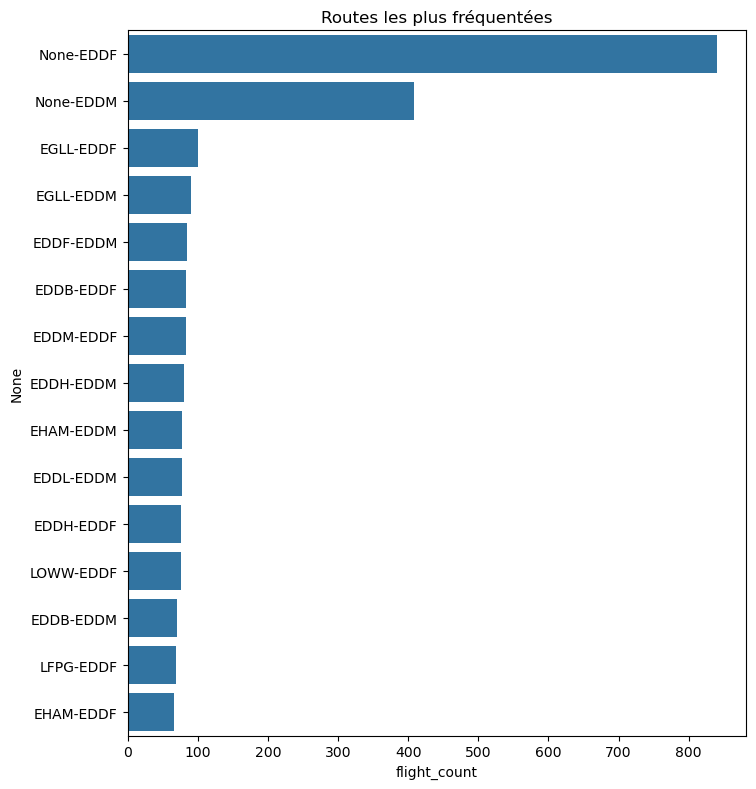

In [17]:

from matplotlib.pylab import mean
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Trouver les routes les plus empruntées
top_routes = nbVols.orderBy(desc("flight_count")).limit(top_n)
top_routes.show()

# Convertir en pandas pour visualisation avec Seaborn
top_routes_pd = top_routes.toPandas()

# Créer des visualisations
plt.figure(figsize=(14, 8))

# Graphique des routes les plus fréquentées
plt.subplot(1, 2, 2)
sns.boxplot
sns.barplot(x="flight_count", y=top_routes_pd.apply(lambda x: f"{x['src']}-{x['dst']}", axis=1), 
            data=top_routes_pd, orient="h")
plt.title("Routes les plus fréquentées")
plt.tight_layout()

plt.savefig("aviation_network_analysis.png")
plt.show()
plt.close()

In [ ]:
# Convertir en pandas pour le pivot
matrix_data = filtered_counts.toPandas()

# Créer la matrice pivot
flight_matrix = matrix_data.pivot(index='estDepartureAirport', columns='estArrivalAirport', values='flight_count')
flight_matrix = flight_matrix.fillna(0)  # Remplacer les NaN par 0

# Créer le heatmap
plt.figure(figsize=(16, 12))
ax = sns.heatmap(
    flight_matrix,
    annot=True,           # Afficher les valeurs
    fmt='g',              # Format des nombres (entiers)
    cmap='YlGnBu',        # Palette de couleurs (jaune-vert-bleu)
    linewidths=0.5,       # Lignes entre les cellules
    cbar_kws={'label': 'Nombre de vols'}
)

# Ajuster les étiquettes et le titre
plt.title('Nombre de vols entre les principaux aéroports', fontsize=16)
plt.xlabel('Destinations', fontsize=12)
plt.ylabel('Origines', fontsize=12)

# Rotation des étiquettes pour la lisibilité
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ajuster la mise en page
plt.tight_layout()

# Sauvegarder et afficher
plt.savefig("/tmp/flight_heatmap_origin_destination.png", dpi=300)
# plt.show()
plt.close()

# Obtenir quelques statistiques sur cette matrice
nonzero_routes = (flight_matrix > 0).sum().sum()
total_possible_routes = len(top_airport_codes) * len(top_airport_codes)
connectivity_ratio = nonzero_routes / total_possible_routes

print(f"Parmi les {top_n} principaux aéroports:")
print(f"Nombre total de routes possibles: {total_possible_routes}")
print(f"Nombre de routes effectivement desservies: {nonzero_routes}")
print(f"Ratio de connectivité: {connectivity_ratio:.2%}")
print(f"Nombre moyen de vols par route active: {flight_matrix.sum().sum() / nonzero_routes:.1f}")

NameError: name 'top_n' is not defined

#### Partie 4

In [15]:
from kafka import KafkaProducer
import requests
import json
import time


OPENSKY_URL = "https://opensky-network.org/api/states/all"
USERNAME = 'NaguiFanAccount'
PASSWORD = 'votre_mot_de_passe'

# Configuration de Kafka
KAFKA_BROKER = 'localhost:9092'  # À adapter selon ton environnement
TOPIC = 'opensky-flights'

# Création du producteur Kafka
producer = KafkaProducer(
    bootstrap_servers=[KAFKA_BROKER],
    value_serializer=lambda x: json.dumps(x).encode('utf-8')
)

def fetch_opensky_data():
    try:
        response = requests.get(OPENSKY_URL, auth=(USERNAME, PASSWORD))
        if response.status_code == 200:
            data = response.json()
            return data['states']
        else:
            print("Erreur lors de la récupération des données :", response.status_code)
            return None
    except Exception as e:
        print("Exception :", e)
        return None

if __name__ == "__main__":
    while True:
        flights_data = fetch_opensky_data()
        if flights_data:
            for flight in flights_data:
                # Envoyer chaque vol à Kafka
                producer.send(TOPIC, value=flight)
                print("Donnée envoyée :", flight)

        time.sleep(60)  # Pause de 60 secondes entre chaque collecte pour respecter le rate limit


NoBrokersAvailable: NoBrokersAvailable